# Data Project

> **Note:** 
> 1. This is a starting point for how to structure your data project 
> 1. The `dataproject.py` file includes functions which can be in this notebook

Import and set magics:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject

## 1 Aggregate inflation in Denmark

We load the data from statistik banken

In [2]:
#%pip install git+https://github.com/alemartinello/dstapi
#%pip install fredapi

In [3]:
# APIs
from fredapi import Fred
from dstapi import DstApi

PRIS113 = DstApi('PRIS113') 

### 1-1 Basics

In [4]:
metro = DstApi('Pris113')

In [5]:
params = {
    'table': 'Pris113',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'TYPE', 'values': ['*']},
        {'code': 'Tid', 'values': ['*']}
    ]
}

In [6]:
metro.get_data(params=params)

,TYPE,TID,INDHOLD
0,Consumer price index,1980M01,33.0
1,Consumer price index,1980M05,34.5
2,Consumer price index,1980M09,35.5
3,Consumer price index,1981M01,36.5
4,Consumer price index,1981M05,38.6
...,...,...,...
544,Consumer price index,2018M12,102.1
545,Consumer price index,2020M03,103.3
546,Consumer price index,2022M05,112.7
547,Consumer price index,2023M01,116.4


In [7]:
# Fetch data and assign to df
df = metro.get_data(params=params)

# Make TID a date field
df['TID'] = pd.to_datetime(df['TID'], format='%YM%m').dt.date

In [8]:
#Sorter data by TID
df = df.sort_values(by='TID').reset_index(drop=True)

In [9]:
# Ensure INDHOLD is numeric
df['INDHOLD'] = pd.to_numeric(df['INDHOLD'], errors='coerce')

# Index the CPI to January 2020 = 100
scaling_factor = round(100 / df.loc[df['TID'] == pd.to_datetime('2020-01-01').date(), 'INDHOLD'].values[0], 2)
df['CPI_Indexed'] = df['INDHOLD'] * scaling_factor

In [10]:
# the month-to-month inflation rate
df['Inflation_Rate'] = df['INDHOLD'].pct_change().round(3)

In [11]:
# the 12-month inflation rate
df['Inflation_Rate_12M'] = (df['INDHOLD'] / df['INDHOLD'].shift(12) - 1).round(3)
display(df)

,TYPE,TID,INDHOLD,CPI_Indexed,Inflation_Rate,Inflation_Rate_12M
0,Consumer price index,1980-01-01,33.0,32.010,NaN,NaN
1,Consumer price index,1980-02-01,33.3,32.301,0.009,NaN
2,Consumer price index,1980-03-01,33.8,32.786,0.015,NaN
3,Consumer price index,1980-04-01,34.0,32.980,0.006,NaN
4,Consumer price index,1980-05-01,34.5,33.465,0.015,NaN
...,...,...,...,...,...,...
544,Consumer price index,2025-05-01,120.4,116.788,0.001,0.016
545,Consumer price index,2025-06-01,120.7,117.079,0.002,0.019
546,Consumer price index,2025-07-01,122.5,118.825,0.015,0.023
547,Consumer price index,2025-08-01,121.7,118.049,-0.007,0.020


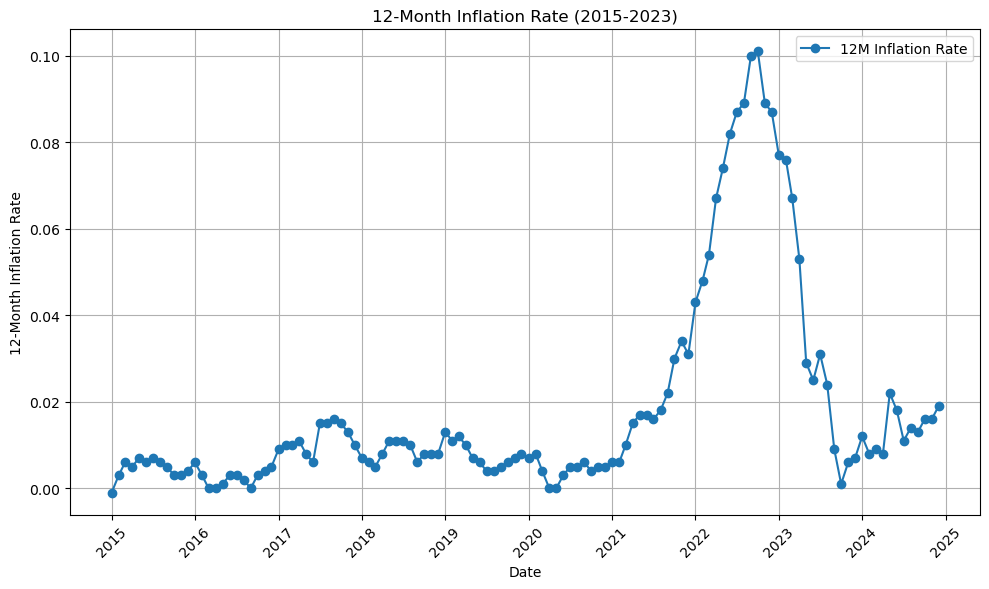

In [12]:
from datetime import date
import matplotlib.pyplot as plt

# Filter 
high_inflation_df = df[(df['TID'] >= date(2015, 1, 1)) & (df['TID'] <= date(2024, 12, 31))]

# Plot 
plt.figure(figsize=(10, 6))
plt.plot(high_inflation_df['TID'], high_inflation_df['Inflation_Rate_12M'], marker='o', label='12M Inflation Rate')
plt.title('12-Month Inflation Rate (2015-2023)')
plt.xlabel('Date')
plt.ylabel('12-Month Inflation Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### 1-2 Instantaneous inflation

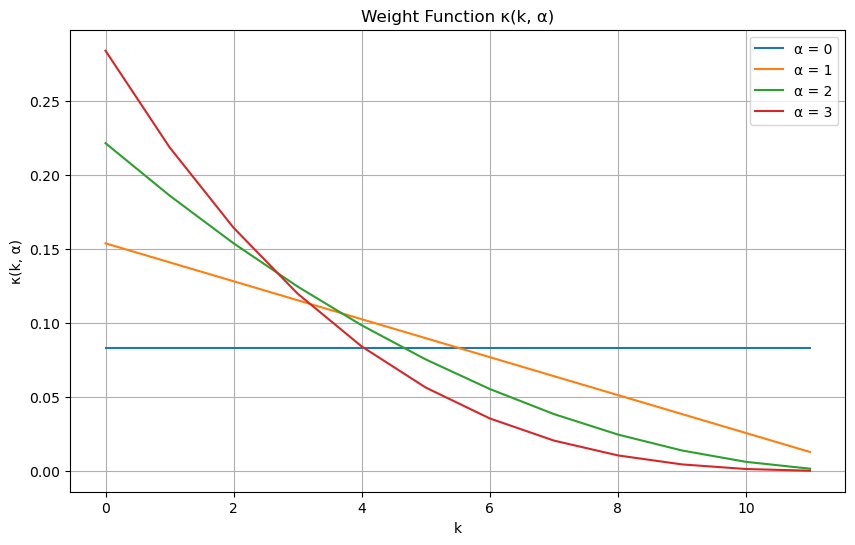

In [13]:
# Step 1: Define and plot κ(k, α)
k_values = np.arange(12)
alpha_values = [0, 1, 2, 3]
T = 12

plt.figure(figsize=(10, 6))
for alpha in alpha_values:
    kappa = (T - k_values) ** alpha / np.sum((T - np.arange(T)) ** alpha)
    plt.plot(k_values, kappa, label=f'α = {alpha}')
plt.xlabel('k')
plt.ylabel('κ(k, α)')
plt.title('Weight Function κ(k, α)')
plt.legend()
plt.grid()
plt.show()

In [14]:
# Step 2: Compute instantaneous inflation π12,α for α ∈ {0, 1, 2, 3}
for alpha in alpha_values:
    # Calculate weights κ(k, α)
    k = np.arange(T)
    kappa = (T - k) ** alpha / np.sum((T - np.arange(T)) ** alpha)
    
    # Compute instantaneous inflation using rolling window
    df[f'Inst_Inf_α{alpha}'] = df['Inflation_Rate'].rolling(window=12).apply(
        lambda x: np.sum(kappa * x[::-1]), raw=True
    )

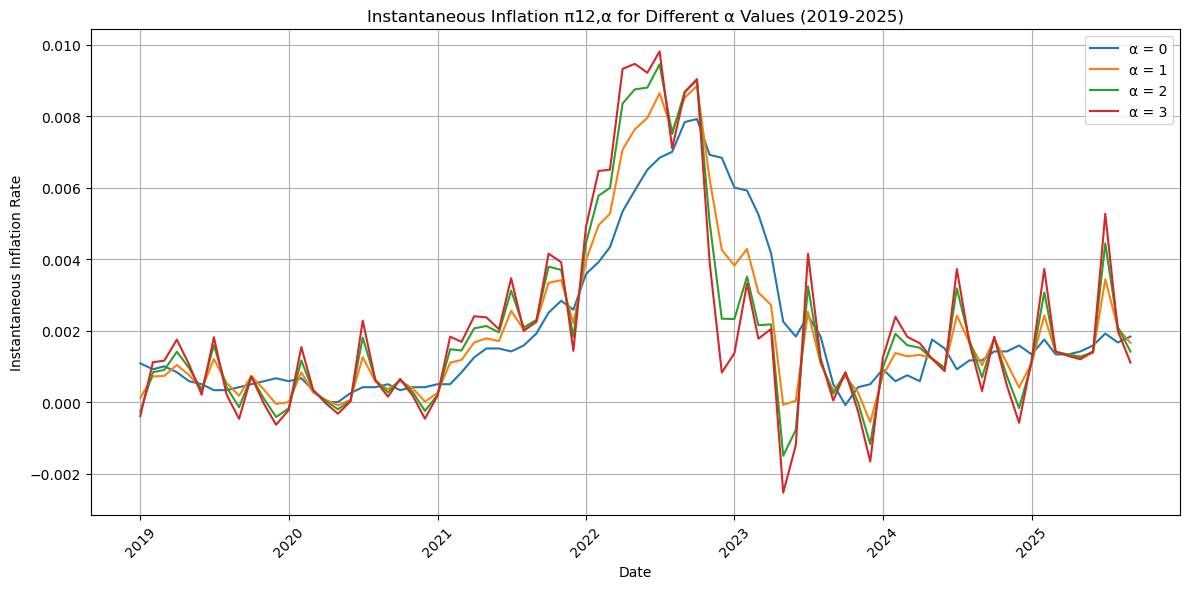

In [15]:
# Filter data from 2019 onwards
df_2019 = df[df['TID'] >= date(2019, 1, 1)]

# Plot instantaneous inflation for different α values
plt.figure(figsize=(12, 6))
for alpha in alpha_values:
    plt.plot(df_2019['TID'], df_2019[f'Inst_Inf_α{alpha}'], label=f'α = {alpha}')

plt.title('Instantaneous Inflation π12,α for Different α Values (2019-2025)')
plt.xlabel('Date')
plt.ylabel('Instantaneous Inflation Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### 2.1

In [16]:
fred = Fred(api_key='150306ebf4d6c4280792e38ca1843100')
data = fred.get_series('CP0000DKM086NEST')

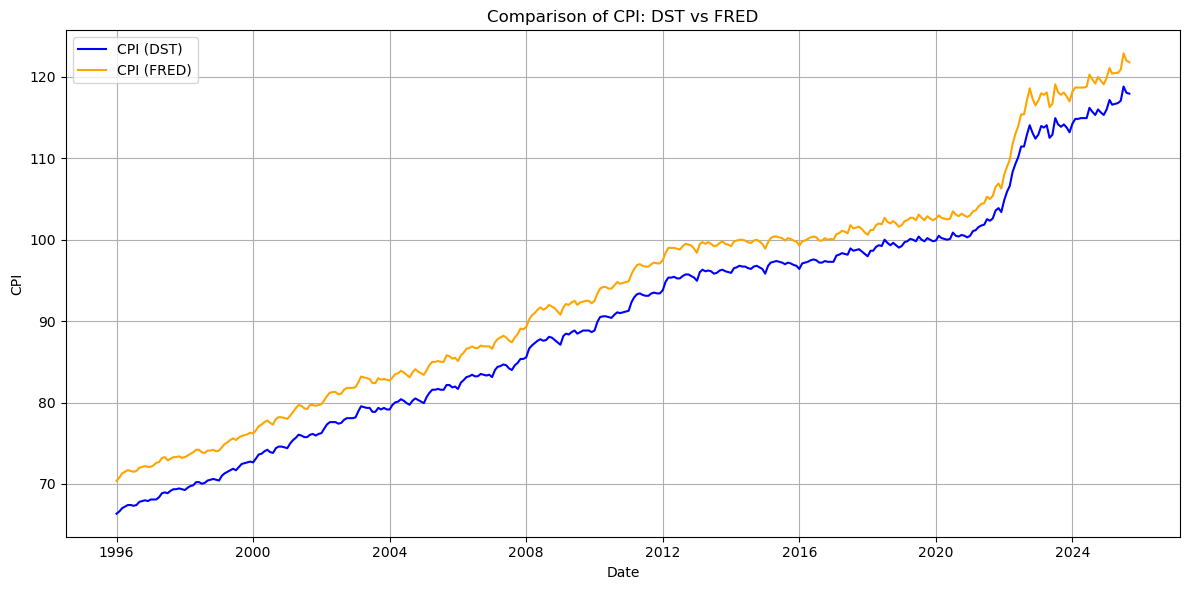

In [17]:
#make TID a date field
df['TID'] = pd.to_datetime(df['TID'])

#Convert the FRED data index to a DataFrame
fred_df = data.reset_index()
fred_df.columns = ['TID', 'CPI_FRED']
fred_df['TID'] = pd.to_datetime(fred_df['TID'])

#Merge the two datasets 
comparison_df = pd.merge(df, fred_df, on='TID', how='inner')

#Plot the CPI from both sources
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['TID'], comparison_df['CPI_Indexed'], label='CPI (DST)', color='blue')
plt.plot(comparison_df['TID'], comparison_df['CPI_FRED'], label='CPI (FRED)', color='orange')
plt.title('Comparison of CPI: DST vs FRED')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


The data from FRED uses OECD data, while DST uses national official statistics. If you want to compare across countries, FRED is the most suitable source, while DST is used for national comparisons.


### Question 2.2

In [18]:
#Define CPI series 
series_dict = {
    'Denmark': 'DNKCPALTT01IXNBM',
    'Austria': 'AUTCPALTT01IXNBM',
    'Euro_Area': 'CP0000EZ19M086NEST',
    'United_States': 'USACPALTT01IXNBM'
}

#Data for each country and combine into a single DataFrame
data = {}
for country, series_id in series_dict.items():
    s = fred.get_series(series_id)
    s = pd.Series(s, name=country)
    data[country] = s

cpi = pd.concat(data.values(), axis=1)
cpi.columns = data.keys()
cpi.index = pd.to_datetime(cpi.index)

#only from 2019 onwards
cpi = cpi[cpi.index >= '2019-01-01']
cpi = cpi.resample('M').last().dropna(how='all')

/var/folders/_q/k18x96qd5vv5vbslnyf8y_3w0000gn/T/ipykernel_99059/2438528875.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cpi = cpi.resample('M').last().dropna(how='all')


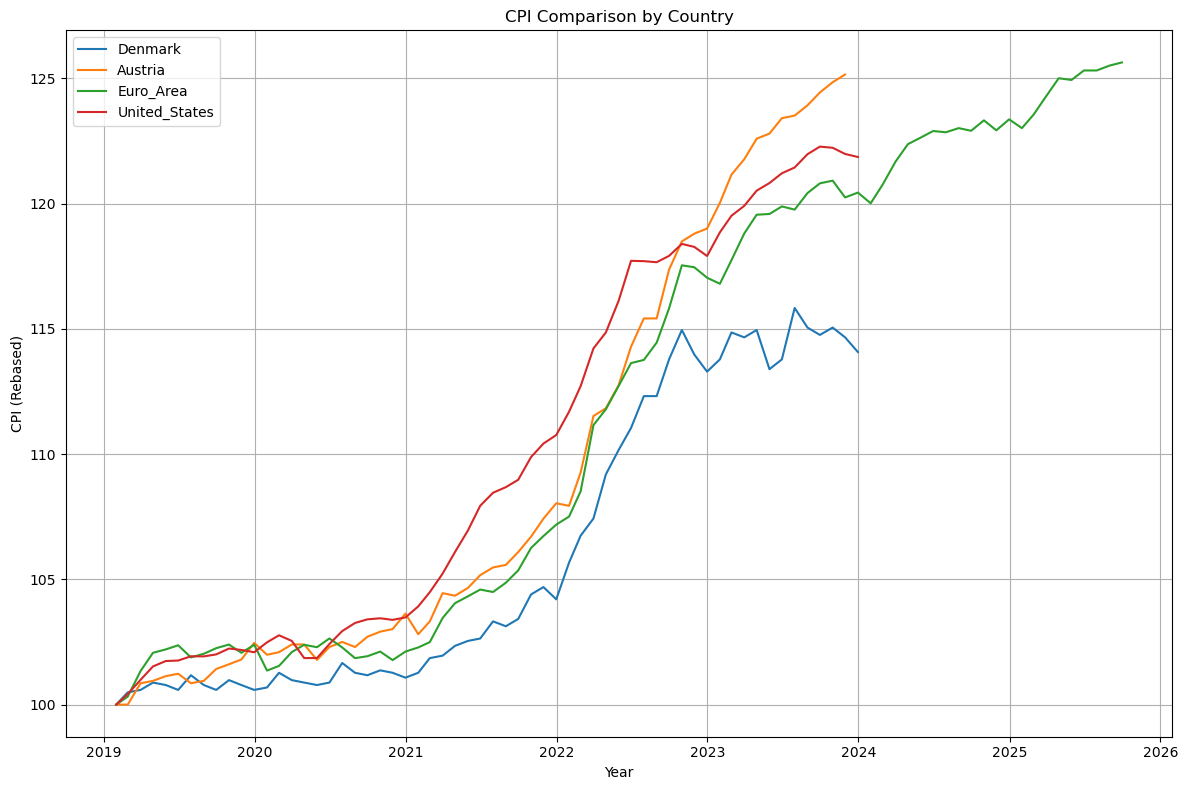

In [19]:
#Makes country list
countries = cpi.columns.tolist()

# Rebase the CPI data to the first available value for each country
cpi_rebased_filtered = cpi / cpi.iloc[0] * 100

#plot graph
plt.figure(figsize=(12, 8))
for country in countries:
    plt.plot(cpi_rebased_filtered.index, cpi_rebased_filtered[country], label=country)

plt.title('CPI Comparison by Country')
plt.xlabel('Year')
plt.ylabel('CPI (Rebased)')
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()


/var/folders/_q/k18x96qd5vv5vbslnyf8y_3w0000gn/T/ipykernel_99059/4173266858.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  hicp_inflation_rate = cpi.pct_change(periods=12).dropna()


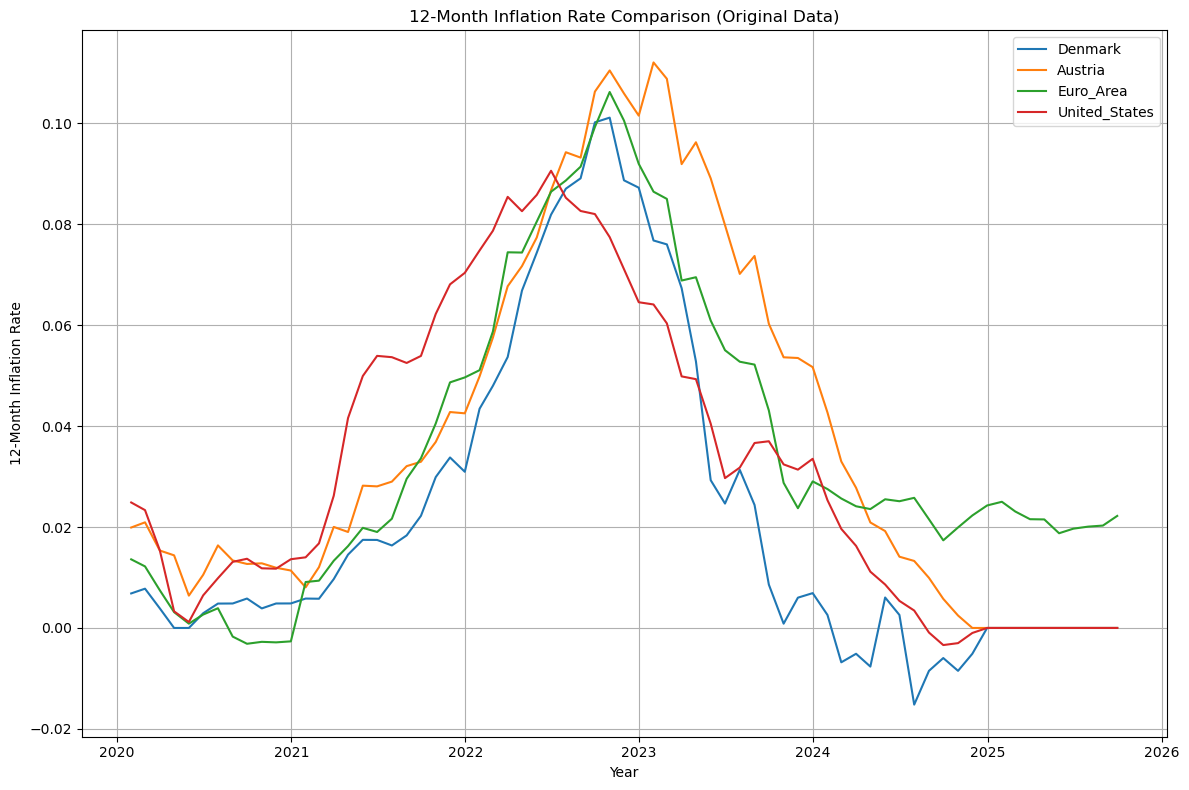

In [20]:
# Calculate the 12-month inflation rate for each country
hicp_inflation_rate = cpi.pct_change(periods=12).dropna()

# Plot the original 12-month inflation rate for each country
plt.figure(figsize=(12, 8))

for country in countries:
    if country in hicp_inflation_rate.columns:
        plt.plot(hicp_inflation_rate.index, hicp_inflation_rate[country], label=country)

plt.title('12-Month Inflation Rate Comparison (Original Data)')
plt.xlabel('Year')
plt.ylabel('12-Month Inflation Rate')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [21]:
# Group by year and calculate min, max, and mean for each year across countries
yearly_stats = hicp_inflation_rate.groupby(hicp_inflation_rate.index.year).agg(['min', 'max', 'mean'])

# Remove rows for the years 2019 (only shows 0)
yearly_stats = yearly_stats[~yearly_stats.index.isin([2019, 2026])].round(3)

#only Euro Area have data for 2025
print(yearly_stats)

     Denmark               Austria               Euro_Area                \
         min    max   mean     min    max   mean       min    max   mean   
2020   0.000  0.008  0.004   0.006  0.021  0.014    -0.003  0.014  0.003   
2021   0.006  0.034  0.019   0.008  0.043  0.028     0.009  0.050  0.026   
2022   0.043  0.101  0.077   0.050  0.110  0.085     0.051  0.106  0.084   
2023   0.001  0.077  0.034   0.052  0.112  0.078     0.024  0.086  0.055   
2024  -0.015  0.006 -0.004   0.000  0.043  0.016     0.017  0.028  0.024   
2025   0.000  0.000  0.000   0.000  0.000  0.000     0.019  0.025  0.021   

     United_States                
               min    max   mean  
2020         0.001  0.025  0.012  
2021         0.014  0.070  0.047  
2022         0.065  0.091  0.080  
2023         0.030  0.064  0.041  
2024        -0.003  0.025  0.007  
2025         0.000  0.000  0.000  
